<a href="https://colab.research.google.com/github/seh363/best-ball-data-bowl/blob/master/Embrace%20EPA%20Variance%20to%20Improve%20Your%20Playoff%20Odds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embrace EPA Variance to Improve Your Playoff Odds

## Participants: Stephen Hoopes
Twitter: @TargetShares

## Introduction

My analysis focuses on a new strategy to improve BBM playoff odds. If you increase the standard deviation of prior year expected points added (EPA) values among your drafted players, you significantly boost your chances of making the playoffs. This strategy increased playoff odds for both BBM3 and BBM2. Increasing prior year EPA standard deviation should be used in concert with other best ball strategies like securing ADP value, stacking, and roster construction as a means to improve player selection.

In [ ]:
!pip install nfl_data_py
import nfl_data_py as nfl
!pip uninstall pandas
!pip install pandas
import pandas as pd
import xgboost as xgb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.optimize import curve_fit
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score, log_loss, confusion_matrix
from sklearn.inspection import PartialDependenceDisplay
from pickle import dump, load
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import os
import urllib.request
from requests import get
from bs4 import BeautifulSoup
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from typing import Any, Dict, Union
import yellowbrick.model_selection as ms

Loading in the packages we'll need for the analysis.

In [ ]:
all_files_2021 = ['part_00.csv', 'part_01.csv', 'part_02.csv', 'part_03.csv', 'part_04.csv', 'part_05.csv']
df2021RS = pd.concat((pd.read_csv(f) for f in all_files_2021), ignore_index=True)

all_filesRS_2022 = ['part_00 mixed RS.csv', 'part_01 mixed RS.csv', 'part_02 mixed RS.csv', 'part_03 mixed RS.csv', 'part_04 mixed RS.csv', 'part_05 mixed RS.csv', 'part_06 mixed RS.csv', 'part_07 mixed RS.csv', 'part_08 mixed RS.csv', 'part_00 fast RS.csv', 'part_01 fast RS.csv', 'part_02 fast RS.csv', 'part_03 fast RS.csv', 'part_04 fast RS.csv', 'part_05 fast RS.csv', 'part_06 fast RS.csv', 'part_07 fast RS.csv', 'part_08 fast RS.csv', 'part_09 fast RS.csv', 'part_10 fast RS.csv', 'part_11 fast RS.csv', 'part_12 fast RS.csv', 'part_13 fast RS.csv', 'part_14 fast RS.csv', 'part_15 fast RS.csv', 'part_16 fast RS.csv', 'part_17 fast RS.csv', 'part_18 fast RS.csv', 'part_19 fast RS.csv', 'part_20 fast RS.csv', 'part_21 fast RS.csv', 'part_22 fast RS.csv', 'part_23 fast RS.csv', 'part_24 fast RS.csv', 'part_25 fast RS.csv', 'part_26 fast RS.csv']
all_filesQ_2022 = ['part_00 quarters.csv', 'part_01 quarters.csv', 'part_02 quarters.csv', 'part_03 quarters.csv', 'part_04 quarters.csv', 'part_05 quarters.csv', 'part_06 quarters.csv', 'part_07 quarters.csv', 'part_08 quarters.csv', 'part_09 quarters.csv']
df2022RS = pd.concat((pd.read_csv(f) for f in all_filesRS_2022), ignore_index=True)
df2022Q = pd.concat((pd.read_csv(f) for f in all_filesQ_2022), ignore_index=True)
df2022RS['playoff_team'] = np.where(df2022RS['tournament_entry_id'].isin(df2022Q['tournament_entry_id']), 1, 0)

Loading in the Underdog data files. My analysis is only concerned with making the playoffs, but I need the 2022 quarterfinals data to know which entries made the playoffs. I'm using this to update the 2022 regular season playoff_team variable so that the value is 1 if the entry made the playoffs and 0 if it didn't. This matches the format of the 2021 data.

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  # take this path if there are no kwargs


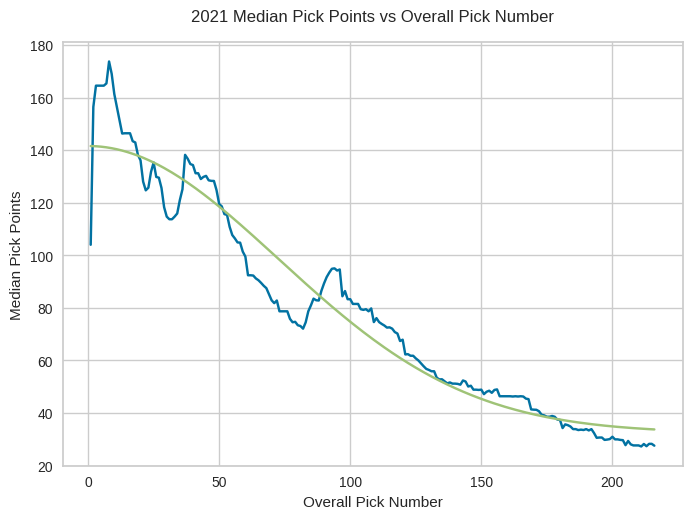

                               draft_id                 draft_time  clock  \
0  00012b23-0f2c-4727-b1ab-05b4a0120a76 2022-08-19 23:49:44.511157  14400   
1  00012b23-0f2c-4727-b1ab-05b4a0120a76 2022-08-19 23:49:44.511157  14400   
2  00012b23-0f2c-4727-b1ab-05b4a0120a76 2022-08-19 23:49:44.511157  14400   
3  00012b23-0f2c-4727-b1ab-05b4a0120a76 2022-08-19 23:49:44.511157  14400   
4  00012b23-0f2c-4727-b1ab-05b4a0120a76 2022-08-19 23:49:44.511157  14400   

                         draft_entry_id                   tournament_entry_id  \
0  8d6dd37f-6a5d-420b-bc9c-b14f77588341  c2fd14f4-cfb8-405e-821d-6f577ce5be45   
1  372c3de1-5233-492f-ab1d-d1455630b9b5  b8f9e652-2362-4df9-b233-acee84698c9f   
2  372c3de1-5233-492f-ab1d-d1455630b9b5  b8f9e652-2362-4df9-b233-acee84698c9f   
3  a7c15a5c-8925-422c-979b-7c60fd0326c5  364bfa02-93db-417b-8c46-793759ef06d2   
4  8d6dd37f-6a5d-420b-bc9c-b14f77588341  c2fd14f4-cfb8-405e-821d-6f577ce5be45   

        tournament_round_draft_entry_id  tournamen

In [ ]:
df2022RS['position_name'] = df2022RS['position_name'].replace('FB', 'RB')
df2022RS = df2022RS.dropna(subset=['tournament_entry_id'])
df2022RS['draft_time'] = pd.to_datetime(df2022RS['draft_time'])
finalADPdf = df2022RS.loc[df2022RS.groupby('player_name')['draft_time'].idxmax()]
df2022RS['Final ADP'] = df2022RS['player_name'].map(finalADPdf.set_index('player_name')['projection_adp'].to_dict())
recodes_finalADP = {0:216}
df2022RS['Final ADP'] = df2022RS['Final ADP'].replace(recodes_finalADP)
df2022RS['Pick ADP Diff'] = df2022RS['overall_pick_number'] - df2022RS['Final ADP']

value2021 = df2021RS.groupby('overall_pick_number', as_index=False).agg({'pick_points': ['median']})
value2021 = value2021.droplevel(0, axis=1)
value2021.columns = ['overall_pick_number', 'median_pick_points']

def value_curve(x, A, B, C):
    y = A*np.exp(-1*B*x**2) + C
    return y
parameters, covariance = curve_fit(value_curve, value2021['overall_pick_number'], value2021['median_pick_points'])
fit_A = parameters[0]
fit_B = parameters[1]
fit_C = parameters[2]
fit_y = value_curve(value2021['overall_pick_number'], fit_A, fit_B, fit_C)
plt.plot(value2021['overall_pick_number'], value2021['median_pick_points'])
plt.plot(value2021['overall_pick_number'], fit_y)
plt.ylabel("Median Pick Points")
plt.xlabel("Overall Pick Number")
plt.title("2021 Median Pick Points vs Overall Pick Number", y=1.03)
plt.show()

df2022RS['pick_value'] = value_curve(df2022RS['overall_pick_number'], fit_A, fit_B, fit_C)
df2022RS['ADP_slot_value'] = value_curve(df2022RS['Final ADP'], fit_A, fit_B, fit_C)
df2022RS['Pick ADP Value'] = df2022RS['ADP_slot_value'] - df2022RS['pick_value']

players = pd.DataFrame(df2022RS['player_name'].unique())
players.columns = ['player_name']
players['Revised Name'] = players['player_name'].astype(str).str[0] + "." + players['player_name'].astype(str).str.split().str[1]
df2022RS['Revised Name'] = df2022RS['player_name'].map(players.set_index('player_name')['Revised Name'].to_dict())
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Aaron Rodgers", "Aa.Rodgers", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Amari Rodgers", "Am.Rodgers", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Breece Hall", "Br.Hall", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Connor Heyward", "Co.Heyward", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Darrel Williams", "Da.Williams", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "David Bell", "Dav.Bell", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "DJ Moore", "Dj.Moore", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Justin Watson", "Ju.Watson", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Marcus Jones", "Ma.Jones", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Michael Carter", "Mi.Carter", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Allen Robinson", "Al.Robinson", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Jonathan Williams", "Jon.Williams", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Jamaal Williams", "Jama.Williams", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Javonte Williams", "Jav.Williams", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Jameson Williams", "Jame.Williams", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Trent Williams", "Tre.Williams", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Tyrell Williams", "Tyr.Williams", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Trayveon Williams", "Tra.Williams", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Ty'Son Williams", "TyS.Williams", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "David Johnson", "Dav.Johnson", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Duke Johnson", "Duk.Johnson", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Diontae Johnson", "Dio.Johnson", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "D'Ernest Johnson", "Der.Johnson", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Tyron Johnson", "Tyr.Johnson", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Ty Johnson", "Ty.Johnson", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Tyler Johnson", "Tyl.Johnson", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Demetrius Harris", "Dem.Harris", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Deonte Harris", "Deo.Harris", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Damien Harris", "Dam.Harris", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Antonio Brown", "Anto.Brown", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "A.J. Brown", "Aj.Brown", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Anthony Brown", "Anth.Brown", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Josh Johnson", "Jos.Johnson", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Jakob Johnson", "Jak.Johnson", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Juwan Johnson", "Juw.Johnson", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Marvin Jones", "Mar.Jones", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Mac Jones", "Mac.Jones", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "J.J. Taylor", "Jj.Taylor", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Jonathan Taylor", "Jon.Taylor", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Jonnu Smith", "Jon.Smith", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Jeff Smith", "Jef.Smith", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Mike Davis", "Mik.Davis", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Malik Davis", "Mal.Davis", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Keenan Allen", "Kee.Allen", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Kyle Allen", "Kyl.Allen", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Michael Thomas", "Mic.Thomas", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Mike Thomas", "Mi.Thomas", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Tremon Smith", "Trem.Smith", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Tre'Quan Smith", "Treq.Smith", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Tyreek Hill", "Tyr.Hill", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Taysom Hill", "Tay.Hill", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "K.J. Hill", "Kj.Hill", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Kylin Hill", "Kyl.Hill", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Tanner Hudson", "Tan.Hudson", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Tommy Hudson", "Tom.Hudson", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Keith Smith", "Kei.Smith", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Kaden Smith", "Kad.Smith", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Tony Jones", "Ton.Jones", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Tim Jones", "Tim.Jones", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Malcolm Brown", "Mal.Brown", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Marquise Brown", "Mar.Brown", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Maxx Williams", "Max.Williams", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Mike Williams", "Mik.Williams", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Ito Smith", "Ito.Smith", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Irv Smith", "Irv.Smith", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "D.J. Montgomery", "Dj.Montgomery", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "David Montgomery", "Dav.Montgomery", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Chris Moore", "Chr.Moore", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "C.J. Moore", "Cj.Moore", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Jared Cook", "Jar.Cook", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "James Cook", "Jam.Cook", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Devin Smith", "Devi.Smith", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "DeVonta Smith", "Devo.Smith", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Collin Johnson", "Col.Johnson", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Cade Johnson", "Cad.Johnson", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Daniel Brown", "Dan.Brown", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Dyami Brown", "Dya.Brown", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "DeSean Jackson", "Des.Jackson", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Deon Jackson", "Deo.Jackson", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Justin Jefferson", "Jus.Jefferson", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Jermar Jefferson", "Jer.Jefferson", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Amon-Ra St. Brown", "A.St. Brown", df2022RS['Revised Name'])
df2022RS['Revised Name'] = np.where(df2022RS['player_name'] == "Equanimeous St. Brown", "E.St. Brown", df2022RS['Revised Name'])

This section is data cleaning and variable creation. I'm changing the few drafted FBs to RBs. I'm changing the draft time data to a format that is easier to handle. I'm also grabbing the closing line ADP number for each player.

The graph above lets us incorporate the value of the draft pick when looking at closing line ADP value. I'm using the 2021 data for the graph since that was all we would have had at the time we drafted in 2022. The blue line shows the median pick points for each overall pick number. There are some big fluctuations by pick, so the green line is a simple model that smooths out these fluctuations. That lets us create a closing line ADP value variable that incorporates the importance of earlier picks.

Finally, I'm creating a revised name variable that lets us merge the Underdog data with nfl_data_py. This works for most names, but I need to change names that would result in duplicates like Aaron and Amari Rodgers both being A.Rodgers.


In [ ]:
df = nfl.import_pbp_data([2021, 2022])
df = df[(df['pass'] == 1) | (df['rush'] == 1)]
df.dropna(subset=['epa', 'posteam', 'defteam'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0023459", "Aa.Rodgers", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0023459", "Aa.Rodgers", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0023459", "Aa.Rodgers", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0036991", "Am.Rodgers", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0036991", "Am.Rodgers", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0036991", "Am.Rodgers", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0028118", "T.Taylor", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0028118", "T.Taylor", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0028118", "T.Taylor", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0034857", "J.Allen", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0034857", "J.Allen", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0034857", "J.Allen", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0032975", "Jon.Williams", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0032975", "Jon.Williams", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0032975", "Jon.Williams", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0033948", "Jama.Williams", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0033948", "Jama.Williams", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0033948", "Jama.Williams", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0036997", "Jav.Williams", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0036997", "Jav.Williams", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0036997", "Jav.Williams", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0037240", "Jame.Williams", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0037240", "Jame.Williams", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0037240", "Jame.Williams", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0027857", "Tre.Williams", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0027857", "Tre.Williams", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0027857", "Tre.Williams", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0032160", "Tyr.Williams", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0032160", "Tyr.Williams", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0032160", "Tyr.Williams", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0035291", "Tra.Williams", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0035291", "Tra.Williams", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0035291", "Tra.Williams", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0036457", "TyS.Williams", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0036457", "TyS.Williams", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0036457", "TyS.Williams", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0032187", "Dav.Johnson", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0032187", "Dav.Johnson", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0032187", "Dav.Johnson", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0032257", "Duk.Johnson", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0032257", "Duk.Johnson", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0032257", "Duk.Johnson", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0035216", "Dio.Johnson", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0035216", "Dio.Johnson", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0035216", "Dio.Johnson", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0035628", "Der.Johnson", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0035628", "Der.Johnson", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0035628", "Der.Johnson", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0035457", "Tyr.Johnson", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0035457", "Tyr.Johnson", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0035457", "Tyr.Johnson", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0035537", "Ty.Johnson", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0035537", "Ty.Johnson", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0035537", "Ty.Johnson", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0036427", "Tyl.Johnson", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0036427", "Tyl.Johnson", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0036427", "Tyl.Johnson", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0030155", "Dem.Harris", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0030155", "Dem.Harris", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0030155", "Dem.Harris", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0035215", "Deo.Harris", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0035215", "Deo.Harris", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0035215", "Deo.Harris", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0035657", "Dam.Harris", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0035657", "Dam.Harris", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0035657", "Dam.Harris", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0027793", "Anto.Brown", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0027793", "Anto.Brown", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0027793", "Anto.Brown", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0035676", "Aj.Brown", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0035676", "Aj.Brown", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0035676", "Aj.Brown", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0037175", "Anth.Brown", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0037175", "Anth.Brown", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0037175", "Anth.Brown", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0026300", "Jos.Johnson", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0026300", "Jos.Johnson", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0026300", "Jos.Johnson", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0035726", "Jak.Johnson", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0035726", "Jak.Johnson", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0035726", "Jak.Johnson", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0036040", "Juw.Johnson", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0036040", "Juw.Johnson", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0036040", "Juw.Johnson", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0029293", "Mar.Jones", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0029293", "Mar.Jones", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0029293", "Mar.Jones", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0036972", "Mac.Jones", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0036972", "Mac.Jones", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0036972", "Mac.Jones", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0036096", "Jj.Taylor", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0036096", "Jj.Taylor", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0036096", "Jj.Taylor", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0036223", "Jon.Taylor", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0036223", "Jon.Taylor", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0036223", "Jon.Taylor", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0033858", "Jon.Smith", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0033858", "Jon.Smith", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0033858", "Jon.Smith", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0035510", "Jef.Smith", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0035510", "Jef.Smith", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0035510", "Jef.Smith", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0032063", "Mik.Davis", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0032063", "Mik.Davis", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0032063", "Mik.Davis", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0037563", "Mal.Davis", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0037563", "Mal.Davis", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0037563", "Mal.Davis", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0030279", "Kee.Allen", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0030279", "Kee.Allen", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0030279", "Kee.Allen", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0034577", "Kyl.Allen", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0034577", "Kyl.Allen", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0034577", "Kyl.Allen", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0032765", "Mic.Thomas", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0032765", "Mic.Thomas", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0032765", "Mic.Thomas", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0033114", "Mi.Thomas", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0033114", "Mi.Thomas", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0033114", "Mi.Thomas", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0034278", "Trem.Smith", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0034278", "Trem.Smith", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0034278", "Trem.Smith", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0034765", "Treq.Smith", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0034765", "Treq.Smith", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0034765", "Treq.Smith", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0033040", "Tyr.Hill", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0033040", "Tyr.Hill", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0033040", "Tyr.Hill", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0033357", "Tay.Hill", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0033357", "Tay.Hill", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0033357", "Tay.Hill", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0036382", "Kj.Hill", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0036382", "Kj.Hill", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0036382", "Kj.Hill", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0036669", "Kyl.Hill", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0036669", "Kyl.Hill", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0036669", "Kyl.Hill", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0034613", "Tan.Hudson", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0034613", "Tan.Hudson", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0034613", "Tan.Hudson", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0036173", "Tom.Hudson", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0036173", "Tom.Hudson", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0036173", "Tom.Hudson", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0030968", "Kei.Smith", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0030968", "Kei.Smith", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0030968", "Kei.Smith", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0034988", "Kad.Smith", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0034988", "Kad.Smith", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0034988", "Kad.Smith", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0035860", "Ton.Jones", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0035860", "Ton.Jones", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0035860", "Ton.Jones", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0036497", "Tim.Jones", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0036497", "Tim.Jones", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0036497", "Tim.Jones", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0031806", "Mal.Brown", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0031806", "Mal.Brown", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0031806", "Mal.Brown", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0035662", "Mar.Brown", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0035662", "Mar.Brown", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0035662", "Mar.Brown", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0031558", "Max.Williams", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0031558", "Max.Williams", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0031558", "Max.Williams", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0033536", "Mik.Williams", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0033536", "Mik.Williams", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0033536", "Mik.Williams", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0034378", "Ito.Smith", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0034378", "Ito.Smith", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0034378", "Ito.Smith", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0034970", "Irv.Smith", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0034970", "Irv.Smith", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0034970", "Irv.Smith", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0035045", "Dj.Montgomery", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0035045", "Dj.Montgomery", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0035045", "Dj.Montgomery", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0035685", "Dav.Montgomery", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0035685", "Dav.Montgomery", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0035685", "Dav.Montgomery", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0032398", "Chr.Moore", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0032398", "Chr.Moore", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0032398", "Chr.Moore", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0035327", "Cj.Moore", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0035327", "Cj.Moore", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0035327", "Cj.Moore", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0027061", "Jar.Cook", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0027061", "Jar.Cook", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0027061", "Jar.Cook", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0037248", "Jam.Cook", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0037248", "Jam.Cook", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0037248", "Jam.Cook", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0031934", "Devi.Smith", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0031934", "Devi.Smith", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0031934", "Devi.Smith", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0036912", "Devo.Smith", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0036912", "Devo.Smith", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0036912", "Devo.Smith", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0036254", "Col.Johnson", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0036254", "Col.Johnson", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0036254", "Col.Johnson", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0036810", "Cad.Johnson", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0036810", "Cad.Johnson", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0036810", "Cad.Johnson", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0032098", "Dan.Brown", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0032098", "Dan.Brown", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0032098", "Dan.Brown", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0036626", "Dya.Brown", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0036626", "Dya.Brown", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0036626", "Dya.Brown", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0026189", "Des.Jackson", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0026189", "Des.Jackson", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0026189", "Des.Jackson", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0036493", "Deo.Jackson", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0036493", "Deo.Jackson", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0036493", "Deo.Jackson", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0036322", "Jus.Jefferson", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0036322", "Jus.Jefferson", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0036322", "Jus.Jefferson", df['receiver_player_name'])

df['passer_player_name'] = np.where(df['passer_player_id'] == "00-0036670", "Jer.Jefferson", df['passer_player_name'])
df['rusher_player_name'] = np.where(df['rusher_player_id'] == "00-0036670", "Jer.Jefferson", df['rusher_player_name'])
df['receiver_player_name'] = np.where(df['receiver_player_id'] == "00-0036670", "Jer.Jefferson", df['receiver_player_name'])

Loading in the play-by-play data for the 2021 and 2022 seasons from nfl_data_py and updating player names for those that were duplicates.

In [ ]:
df2021 = df[df['season'] == 2021]
df2022 = df[df['season'] == 2022]

Splitting the nfl_data_py play-by-play data into two different dataframes by season.

In [ ]:
df2021season = nfl.import_seasonal_data([2021])

df2021season['Passing Player'] = df2021season['player_id'].map(df2021.set_index('passer_player_id')['passer_player_name'].to_dict())
df2021season['Rushing Player'] = df2021season['player_id'].map(df2021.set_index('rusher_player_id')['rusher_player_name'].to_dict())
df2021season['Receiving Player'] = df2021season['player_id'].map(df2021.set_index('receiver_player_id')['receiver_player_name'].to_dict())
df2021season['Player Names'] = df2021season[['Passing Player', 'Rushing Player', 'Receiving Player']].bfill(axis=1).iloc[:, 0]

df2021season['Total EPA'] = df2021season['passing_epa'] + df2021season['rushing_epa'] + df2021season['receiving_epa']
df2021season['EPA Per Game'] = df2021season['Total EPA'] / df2021season['games']

Pulling in the 2021 seasonal data from nfl_data_py. This data provides passing, rushing, and receiving EPA by player. This is the prior year EPA data I need for the analysis. Again, I'm using 2021 here because that's all we would have had for our 2022 drafts. I'm calculating the Total EPA number for each player, which is the sum of the passing, rushing, and receiving EPA values from nfl_data_py. Then, I'm dividing by the number of games that each player played in 2021 to get a per game value. I'm using per game values because this allows us to compare players with different number of games played due to injuries, suspensions, etc.

In [ ]:
passer_list22 = df2022['passer_player_name'].unique()
rusher_list22 = df2022['rusher_player_name'].unique()
receiver_list22 = df2022['receiver_player_name'].unique()
passer_list22 = passer_list22[passer_list22 != np.array(None)]
rusher_list22 = rusher_list22[rusher_list22 != np.array(None)]
receiver_list22 = receiver_list22[receiver_list22 != np.array(None)]
player_list22 = np.unique(np.concatenate((passer_list22, rusher_list22, receiver_list22),0))
teamdf = pd.DataFrame(player_list22)
teamdf.columns = ['Player Names']
teamdf['Passing Team'] = teamdf['Player Names'].map(df2022[['passer_player_name', 'posteam']].set_index('passer_player_name')['posteam'].to_dict())
teamdf['Rushing Team'] = teamdf['Player Names'].map(df2022[['rusher_player_name', 'posteam']].set_index('rusher_player_name')['posteam'].to_dict())
teamdf['Receiving Team'] = teamdf['Player Names'].map(df2022[['receiver_player_name', 'posteam']].set_index('receiver_player_name')['posteam'].to_dict())
teamdf['Team'] = teamdf[['Passing Team', 'Rushing Team', 'Receiving Team']].bfill(axis=1).iloc[:, 0]
teamdf['Player Names'] = np.where(teamdf['Player Names'] == "D.Moore", "Dj.Moore", teamdf['Player Names'])
teamdf['Team'] = np.where(teamdf['Player Names'] == "Drew Lock", "SEA", teamdf['Team'])
teamdf['Team'] = np.where(teamdf['Player Names'] == "Calvin Austin", "PIT", teamdf['Team'])

Combining each player with their 2022 NFL team. I need this information to determine whether an entry stacked their QB with WRs or TEs on the same team.

In [ ]:
df2022RS['EPA Per Game 2021'] = df2022RS['Revised Name'].map(df2021season.set_index('Player Names')['EPA Per Game'].to_dict())
df2022RS['Team'] = df2022RS['Revised Name'].map(teamdf.set_index('Player Names')['Team'].to_dict())
recodes_epa = {np.nan:0}
df2022RS['EPA Per Game 2021'] = df2022RS['EPA Per Game 2021'].replace(recodes_epa)

Pulling in the prior year EPA and current year team variables into the Underdog dataframe. If an EPA per game value doesn't exist for a player in 2021, due to injury or if the player was a 2022 rookie, then I'm setting the EPA per game value to 0.

In [ ]:
def getAges(superflex=False, include_picks=False):
    url = 'https://keeptradecut.com/dynasty-rankings?filters=QB|WR|RB|TE'
    if include_picks:
        url = url + '|RDP'
    if not superflex:
        url = url + '&format=1'
    players = BeautifulSoup(get(url).text, features='lxml').select('div[id=rankings-page-rankings] > div')
    player_list = []
    for player in players:
        e = player.select('div[class=player-name] > p > a')[0]
        pid = e.get('href').split('/')[-1]
        name = e.text.strip()
        try:
            team = player.select('div[class=player-name] > p > span[class=player-team]')[0].text.strip()
        except:
            team = None
        position = player.select('p[class=position]')[0].text.strip()[:2]
        position = 'PICK' if position == 'PI' else position
        try:
            age = player.select('div[class=position-team] > p')[1].text.strip()[:2]
        except:
            age = None
        val = int(player.select('div[class=value]')[0].text.strip())
        val_colname = 'Value' if superflex else 'Value'
        player_list.append({'PlayerID':pid,'Name':name,'Team':team,'Position':position,'Age':age,val_colname:val})
    return pd.DataFrame(player_list)

agesdf = getAges(superflex=False, include_picks=False)
agesdf['Age'] = agesdf['Age'].astype(int) - 1

Pulling in player ages from KeepTradeCut. I'm subtracting each player's age by 1 because I want their age before the 2022 season rather than their current age.

In [ ]:
df2022RS['Age'] = df2022RS['player_name'].map(agesdf.set_index('Name')['Age'].to_dict())
df2022RS['Age'] = np.where(df2022RS['player_name'] == "A.J. Green", 33, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Abram Smith", 23, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Alex Bachman", 25, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Andy Isabella", 25, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Antoine Weasley", 24, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Antonio Brown", 33, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Antonio Williams", 24, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Bo Melton", 22, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Brandon Allen", 29, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Brandon Bolden", 32, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Brandon Johnson", 23, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Brandon Powell", 26, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Breshad Perriman", 28, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Calvin Austin", 23, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Cam Newton", 32, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Cameron Brate", 30, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Carlos Hyde", 31, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Charlie Woerner", 24, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Chris Carson", 27, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Chris Conley", 29, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Cole Beasley", 32, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Cole Turner", 22, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Connor Heyward", 23, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Corey Clement", 27, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Cyril Grayson", 28, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Damien Williams", 31, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Dante Pettis", 26, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Darwin Thompson", 26, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "David Johnson", 30, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Demetrius Harris", 30, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Derrius Guice", 24, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Devonta Freeman", 30, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "DJ Chark", 25, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "DJ Moore", 25, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Durham Smythe", 26, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Emmanuel Sanders", 35, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Freddie Swain", 23, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Gabe Davis", 23, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Giovani Bernard", 30, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Irv Smith", 23, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Jakeem Grant", 29, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "James White", 30, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Jared Bernhardt", 24, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Jared Cook", 35, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Jashaun Corbin", 21, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Jeff Driskel", 29, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Jeff Wilson", 26, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Jerreth Sterns", 22, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Jimmy Graham", 35, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Jody Fortson", 26, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Joe Flacco", 37, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "John Ross", 26, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Jonathan Ward", 24, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Jonathan Williams", 28, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Jordan Akins", 30, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Josh Gordon", 31, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Joshua Palmer", 22, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Justin Watson", 26, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Juwann Winfree", 25, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Keelan Cole", 29, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Kendall Blanton", 26, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Kendall Hinton", 25, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Kennedy Brooks", 23, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Kenneth Walker", 21, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Kenny Golladay", 28, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Kevin Austin", 22, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Kristian Wilkerson", 25, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Kyle Juszczyk", 31, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Kyle Rudolph", 32, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Laquon Treadwell", 26, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Leddie Brown", 23, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Malik Williams", 23, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Mark Ingram", 32, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Matt Barkley", 31, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Melvin Gordon", 29, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Michael Bandy", 24, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Mike Davis", 29, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Mike Glennon", 32, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Mitch Trubisky", 27, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Montrell Washington", 23, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Nick Boyle", 29, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Nick Foles", 33, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Pharaoh Brown", 27, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Phillip Lindsay", 27, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Pierre Strong", 23, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Racey McMath", 22, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Ray-Ray McCloud", 25, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Rex Burkhead", 31, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Ricky Seals-Jones", 27, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Rob Gronkowski", 32, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Royce Freeman", 26, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Samori Toure", 24, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Seth Williams", 22, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Simi Fehoko", 24, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Sony Michel", 27, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "T.J. Vasher", 23, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "T.Y. Hilton", 32, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Tajae Sharpe", 27, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Tanner Conner", 24, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Tavon Austin", 31, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Tom Brady", 44, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Travis Fulgham", 26, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Travis Jonsen", 25, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Ty Montgomery", 29, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Tyrod Taylor", 32, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Tyron Johnson", 26, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Ty'Son Williams", 25, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Victor Bolden", 27, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "William Fuller", 28, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "ZaQuandre White", 23, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Matt Ryan", 36, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Antoine Wesley", 24, df2022RS['Age'])
df2022RS['Age'] = np.where(df2022RS['player_name'] == "Randall Cobb", 32, df2022RS['Age'])

Pulling player ages into the Underdog dataframe and adjusting for players that either weren't listed in KeepTradeCut or didn't find a match due to different naming conventions.

In [ ]:
QBgrouped = df2022RS[df2022RS['position_name'] == 'QB'].groupby(['tournament_entry_id','Team'])['Team'].count()
WRgrouped = df2022RS[df2022RS['position_name'] == 'WR'].groupby(['tournament_entry_id','Team'])['Team'].count()
TEgrouped = df2022RS[df2022RS['position_name'] == 'TE'].groupby(['tournament_entry_id','Team'])['Team'].count()
QBdf = pd.DataFrame(QBgrouped)
QBdf.columns = ['QB Team Count']
QBdf = QBdf.reset_index()
WRdf = pd.DataFrame(WRgrouped)
WRdf.columns = ['WR Team Count']
WRdf = WRdf.reset_index()
TEdf = pd.DataFrame(TEgrouped)
TEdf.columns = ['TE Team Count']
TEdf = TEdf.reset_index()
stackdf1 = pd.merge(QBdf, WRdf, how='left', left_on=['tournament_entry_id','Team'], right_on = ['tournament_entry_id','Team'])
stackdf = pd.merge(stackdf1, TEdf, how='left', left_on=['tournament_entry_id','Team'], right_on = ['tournament_entry_id','Team'])
recodes_stack = {np.nan:0}
stackdf['WR Team Count'] = stackdf['WR Team Count'].replace(recodes_stack)
stackdf['TE Team Count'] = stackdf['TE Team Count'].replace(recodes_stack)
stackdf['WR and TE Count'] = (stackdf['WR Team Count'] + stackdf['TE Team Count']).astype(int)
stackgroup = stackdf.groupby(['tournament_entry_id'])[['QB Team Count', 'WR and TE Count']].sum()
stackgroupdf = pd.DataFrame(stackgroup).reset_index()
stackgroupdf['Stack Ratio'] = stackgroupdf['WR and TE Count'] / stackgroupdf['QB Team Count']

Creating a Stack Ratio variable. The numerator is the number of WRs and TEs on the same NFL team as the QBs an entry drafted. The denominator is the total number of drafted QBs. A value of 0 means that an entry didn't have any WRs or TEs on the same team as their drafted QBs, while higher values mean that an entry stacked many WRs or TEs with their drafted QBs.

In [ ]:
grouped = df2022RS.groupby(['tournament_entry_id', 'position_name'], as_index=False).agg({'overall_pick_number': ['mean', 'median', 'min', 'max', 'std', 'count']})
grouped = grouped.droplevel(1, axis=1)
grouped.columns = ['tournament_entry_id', 'position_name', 'Pick Mean', 'Pick Median', 'Pick Min', 'Pick Max', 'Pick Std', 'Count']

grouped2 = df2022RS.groupby(['tournament_entry_id', 'position_name'], as_index=False).agg({'Pick ADP Value': ['sum']})
grouped2 = grouped2.droplevel(1, axis=1)
grouped2.columns = ['tournament_entry_id', 'position_name', 'ADP Value Sum']

grouped3 = df2022RS.groupby(['tournament_entry_id', 'position_name']).agg(mod=('bye_week', lambda x: x.value_counts().values[0])).reset_index()
grouped3 = grouped3.pivot_table(values='mod', index='tournament_entry_id', columns='position_name', aggfunc='first')
grouped3 = grouped3.reset_index()
grouped3.columns = ['tournament_entry_id', 'QB Shared Bye Weeks', 'RB Shared Bye Weeks', 'TE Shared Bye Weeks', 'WR Shared Bye Weeks']

grouped4 = df2022RS.groupby(['tournament_entry_id', 'position_name'], as_index=False).agg({'EPA Per Game 2021': ['sum', 'std']})
grouped4 = grouped4.droplevel(1, axis=1)
grouped4.columns = ['tournament_entry_id', 'position_name', 'EPA Per Game', 'EPA Per Game Std']

grouped5 = df2022RS.groupby(['tournament_entry_id', 'position_name'], as_index=False).agg({'Age': ['median']})
grouped5 = grouped5.droplevel(1, axis=1)
grouped5.columns = ['tournament_entry_id', 'position_name', 'Median Age']

new = grouped.merge(grouped2, left_on=['tournament_entry_id', 'position_name'], right_on=['tournament_entry_id', 'position_name'])

new4 = new.merge(grouped4, left_on=['tournament_entry_id', 'position_name'], right_on=['tournament_entry_id', 'position_name'])

new5 = new4.merge(grouped5, left_on=['tournament_entry_id', 'position_name'], right_on=['tournament_entry_id', 'position_name'])

new2 = df2022RS.merge(new5, left_on=['tournament_entry_id', 'position_name'], right_on=['tournament_entry_id', 'position_name'])

new3 = pd.DataFrame()
new3['tournament_entry_id'] = new2['tournament_entry_id'].unique()

for x in ['QB', 'WR', 'RB', 'TE']:
  new3[x+' Pick Mean'] = new3['tournament_entry_id'].map(new2[new2['position_name'] == x].set_index('tournament_entry_id')['Pick Mean'].to_dict())
  new3[x+' Pick Median'] = new3['tournament_entry_id'].map(new2[new2['position_name'] == x].set_index('tournament_entry_id')['Pick Median'].to_dict())
  new3[x+' Pick Min'] = new3['tournament_entry_id'].map(new2[new2['position_name'] == x].set_index('tournament_entry_id')['Pick Min'].to_dict())
  new3[x+' Pick Max'] = new3['tournament_entry_id'].map(new2[new2['position_name'] == x].set_index('tournament_entry_id')['Pick Max'].to_dict())
  new3[x+' Pick Std'] = new3['tournament_entry_id'].map(new2[new2['position_name'] == x].set_index('tournament_entry_id')['Pick Std'].to_dict())
  new3[x+' Count'] = new3['tournament_entry_id'].map(new2[new2['position_name'] == x].set_index('tournament_entry_id')['Count'].to_dict())
  new3[x+' ADP Value Sum'] = new3['tournament_entry_id'].map(new2[new2['position_name'] == x].set_index('tournament_entry_id')['ADP Value Sum'].to_dict())
  new3[x+' EPA Per Game 2021'] = new3['tournament_entry_id'].map(new2[new2['position_name'] == x].set_index('tournament_entry_id')['EPA Per Game 2021'].to_dict())
  new3[x+' EPA Per Game Std'] = new3['tournament_entry_id'].map(new2[new2['position_name'] == x].set_index('tournament_entry_id')['EPA Per Game Std'].to_dict())
  new3[x+' Median Age'] = new3['tournament_entry_id'].map(new2[new2['position_name'] == x].set_index('tournament_entry_id')['Median Age'].to_dict())

new3['playoff_team'] = new3['tournament_entry_id'].map(new2.set_index('tournament_entry_id')['playoff_team'].to_dict())
new3['roster_points'] = new3['tournament_entry_id'].map(new2.set_index('tournament_entry_id')['roster_points'].to_dict())

entries = new3.merge(grouped3, left_on=['tournament_entry_id'], right_on = ['tournament_entry_id'])
entries['QB Shared Bye Weeks %'] = entries['QB Shared Bye Weeks'] / entries['QB Count']
entries['RB Shared Bye Weeks %'] = entries['RB Shared Bye Weeks'] / entries['RB Count']
entries['WR Shared Bye Weeks %'] = entries['WR Shared Bye Weeks'] / entries['WR Count']
entries['TE Shared Bye Weeks %'] = entries['TE Shared Bye Weeks'] / entries['TE Count']

entries['Stack Ratio'] = entries['tournament_entry_id'].map(stackgroupdf.set_index('tournament_entry_id')['Stack Ratio'].to_dict())
entries['QB ADP Per Count'] = entries['QB ADP Value Sum'] / entries['QB Count']
entries['RB ADP Per Count'] = entries['RB ADP Value Sum'] / entries['RB Count']
entries['WR ADP Per Count'] = entries['WR ADP Value Sum'] / entries['WR Count']
entries['TE ADP Per Count'] = entries['TE ADP Value Sum'] / entries['TE Count']
entries['QB EPA Per Count'] = entries['QB EPA Per Game 2021'] / entries['QB Count']
entries['RB EPA Per Count'] = entries['RB EPA Per Game 2021'] / entries['RB Count']
entries['WR EPA Per Count'] = entries['WR EPA Per Game 2021'] / entries['WR Count']
entries['TE EPA Per Count'] = entries['TE EPA Per Game 2021'] / entries['TE Count']
entries = entries.drop(columns = ['QB Shared Bye Weeks', 'RB Shared Bye Weeks', 'TE Shared Bye Weeks', 'WR Shared Bye Weeks', 'QB ADP Value Sum', 'RB ADP Value Sum', 'WR ADP Value Sum', 'TE ADP Value Sum', 'QB EPA Per Game 2021', 'RB EPA Per Game 2021', 'WR EPA Per Game 2021', 'TE EPA Per Game 2021', 'QB Pick Std', 'WR Pick Std', 'RB Pick Std', 'TE Pick Std'])

Creating a new dataframe where each row is an individual entry in BBM3. For each entry, I'm creating roster construction variables, closing line ADP value by position, shared bye week variables, and median age by position.

Additionally, I'm creating the standard deviation of prior year EPA by position, which will be our focus. Standard deviation is the average amount of variability in your dataset; a larger number means more variability, while a smaller number means less.


In [ ]:
recodes_std = {np.nan:0}
entries['QB EPA Per Game Std'] = entries['QB EPA Per Game Std'].replace(recodes_std)
entries['RB EPA Per Game Std'] = entries['RB EPA Per Game Std'].replace(recodes_std)
entries['WR EPA Per Game Std'] = entries['WR EPA Per Game Std'].replace(recodes_std)
entries['TE EPA Per Game Std'] = entries['TE EPA Per Game Std'].replace(recodes_std)
entries = entries.dropna()
xgbdf = entries[['QB Pick Min', 'QB Count', 'QB ADP Per Count', 'QB EPA Per Count', 'QB EPA Per Game Std', 'QB Median Age', 'WR Pick Min', 'WR Count', 'WR ADP Per Count', 'WR EPA Per Count', 'WR EPA Per Game Std', 'WR Median Age', 'RB Pick Min', 'RB Count', 'RB ADP Per Count', 'RB EPA Per Count', 'RB EPA Per Game Std', 'RB Median Age', 'TE Pick Min', 'TE Count', 'TE ADP Per Count', 'TE EPA Per Count', 'TE EPA Per Game Std', 'TE Median Age', 'Stack Ratio', 'QB Shared Bye Weeks %', 'RB Shared Bye Weeks %', 'WR Shared Bye Weeks %', 'TE Shared Bye Weeks %', 'playoff_team']]
X_train, X_test, y_train, y_test = train_test_split(xgbdf[xgbdf.columns.tolist()[:-1]], xgbdf[xgbdf.columns.tolist()[-1]], test_size=0.2, random_state=123)
xgbdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 451192 entries, 0 to 451199
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   QB Pick Min            451192 non-null  int64  
 1   QB Count               451192 non-null  int64  
 2   QB ADP Per Count       451192 non-null  float64
 3   QB EPA Per Count       451192 non-null  float64
 4   QB EPA Per Game Std    451192 non-null  float64
 5   QB Median Age          451192 non-null  float64
 6   WR Pick Min            451192 non-null  int64  
 7   WR Count               451192 non-null  int64  
 8   WR ADP Per Count       451192 non-null  float64
 9   WR EPA Per Count       451192 non-null  float64
 10  WR EPA Per Game Std    451192 non-null  float64
 11  WR Median Age          451192 non-null  float64
 12  RB Pick Min            451192 non-null  int64  
 13  RB Count               451192 non-null  int64  
 14  RB ADP Per Count       451192 non-nu

Adjusting the per game EPA standard deviation values to 0 for those entries that didn't have a value. This is due to an entry only drafting one QB or one TE.

As an example of these standard deviation variables, consider an entry that drafts 7 WRs. Each of these 7 WRs would have an EPA value from 2021. We would've had access to that value while drafting in 2022. If the EPA values of those 7 WRs were very different from each other, the "WR EPA Per Game Std" would be very high for this entry.

Alternatively, there was an entry in BBM3 that drafted 7 WRs and all were rookies. Given that these players were rookies in 2022, none of them had an EPA value in 2021. As a result, the standard deviation of those WRs is 0 and the lowest among all entries. For some foreshadowing, that entry did not make the playoffs.

I'm splitting the data into training and test datasets. I'm holding out the test set during model creation to evaluate how good the model is at predicting the playoff odds for an entry it hasn't seen before.


In [ ]:
def hyperparameter_tuning(space: Dict[str, Union[float, int]], X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, metric:callable=log_loss) -> Dict[str, Any]:
  space = {k: val for k,val in space.items()}
  model = xgb.XGBClassifier(**space, tree_method = "gpu_hist")
  evaluation = [(X_train, y_train), (X_test, y_test)]
  model.fit(X_train, y_train, eval_set=evaluation, verbose=False)
  pred = model.predict(X_test)
  score = metric(y_test, pred)
  return {'loss': score, 'status': STATUS_OK, 'model': model}

options = {'max_depth': scope.int(hp.quniform('max_depth', 3, 12, 1)),
           'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
           'subsample': hp.uniform('subsample', 0.6, 1),
           'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
           'reg_alpha': scope.int(hp.uniform('reg_alpha', 0, 10)),
           'reg_lambda': hp.uniform('reg_lambda', 1, 10),
           'gamma': hp.loguniform('gamma', -10, 10),
           'learning_rate': hp.loguniform('learning_rate', -7, 0),
           'random_state': 123
           }

trials = Trials()
best = fmin(fn=lambda space: hyperparameter_tuning(space, X_train, y_train, X_test, y_test), space=options, algo=tpe.suggest, max_evals=500, trials=trials)
print(best)

100%|██████████| 500/500 [22:54<00:00,  2.75s/trial, best loss: 5.587547149905915]
{'colsample_bytree': 0.8285356201259303, 'gamma': 0.0007555550443856257, 'learning_rate': 0.38774412954507986, 'max_depth': 6.0, 'min_child_weight': 1.7657674260083882, 'reg_alpha': 6.586852736463355, 'reg_lambda': 5.751826973952633, 'subsample': 0.9679153587136896}


The above code tunes the hyperparameters of an XGBoost model that predicts if an entry will make the playoffs. I'm using Hyperopt, which uses Bayesian optimization. Within the ranges I'm specifying for each hyperparameter, the code searches the space using a probabilistic model to select the next set of hyperparameters to try. After 500 rounds, it provides the hyperparameters that performed the best.

In [ ]:
params = {'max_depth': 6, 'min_child_weight': 1.765767426, 'subsample': 0.96791536, 'colsample_bytree': 0.82853562,
          'reg_alpha': 6.586853, 'reg_lambda': 5.751827, 'gamma': 0.000755555, 'learning_rate': 0.38774413, 'random_state': 123}
xg_cl = xgb.XGBClassifier(**params, early_stopping_rounds = 50, n_estimators = 500)
xg_cl.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose=100)
preds_test = xg_cl.predict_proba(X_test)[:,1]
print(xg_cl.score(X_test, y_test))

[0]	validation_0-logloss:0.54450	validation_1-logloss:0.54592
[100]	validation_0-logloss:0.33950	validation_1-logloss:0.36579
[200]	validation_0-logloss:0.31523	validation_1-logloss:0.36189
[274]	validation_0-logloss:0.30120	validation_1-logloss:0.36197
0.8460643402519975


I'm using the hyperparameter set output from the last code block to actually create the XGBoost model. I'm able to predict with 84.6% accuracy in the test set whether an entry in BBM3 made the playoffs. That's better than the comparison metric of 83.3%, which is the accuracy you'd get if you guessed no entry made the playoffs. I'm very happy with this result given the randomness involved in making the playoffs.

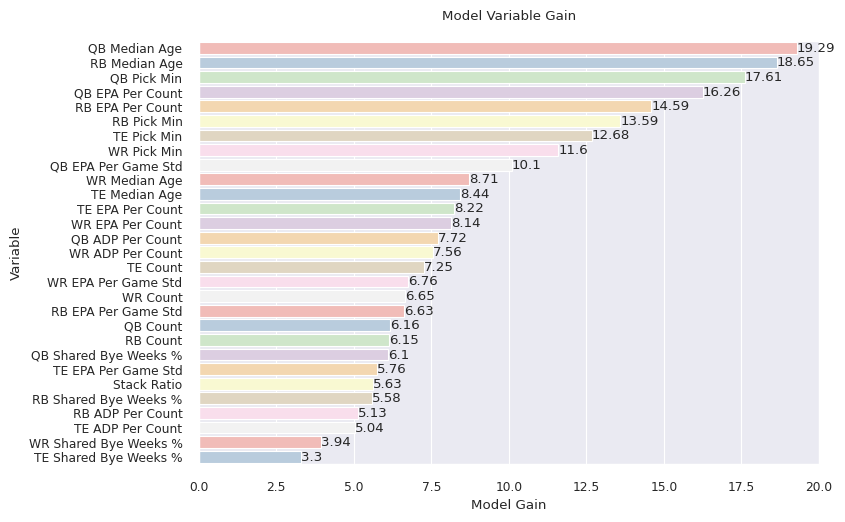

In [ ]:
feature_importance = xg_cl.get_booster().get_score(importance_type= 'gain')
feature_df = pd.DataFrame(feature_importance.items(), columns=['Variable', 'Gain']).sort_values('Gain', ascending=False).round({'Gain': 2})
sns.set_context('paper')
sns.set_style('darkgrid')
column = feature_df['Gain']
plot1 = sns.barplot(x = 'Gain', y = 'Variable', data=feature_df, palette='Pastel1')
plot1.bar_label(plot1.containers[0])
plt.xlim([0, 20])
plt.ylabel("Variable")
plt.xlabel("Model Gain")
plt.title("Model Variable Gain", y=1.03)
plt.show()

The above graph shows how important each variable is when predicting if an entry is going to make the playoffs. The top two variables in our XGBoost model for model gain are the median age of an entry's QBs and RBs. WRs and TEs aren't that far behind, either. The reason why I'm not focusing on these variables is if you replicate this analysis for BBM2, the median QB age that performed the best flipped. I'm looking for a strategy that is replicable. For example, in BBM3 you wanted young QBs, while in BBM2, you wanted old QBs as Tom Brady's outstanding 2021 performance skewed the graph for QBs as a whole.

## Partial Dependence Plots of EPA Per Game Standard Deviation

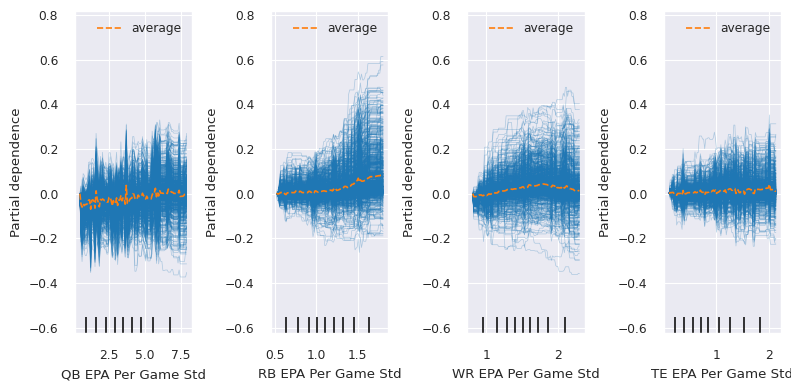

In [ ]:
fig, axes = plt.subplots(ncols=4, figsize=(8,4))
PartialDependenceDisplay.from_estimator(xg_cl, X_train, features=['QB EPA Per Game Std', 'RB EPA Per Game Std', 'WR EPA Per Game Std', 'TE EPA Per Game Std'], centered = True, kind='both', ax=axes)
fig.tight_layout()

The graphs above are partial dependence plots (PDPs) for the standard deviation of the prior year EPA values of an entry by position. PDPs represent the average behavior of the model for a given variable while holding all other variables constant. In this scenario, the orange lines represent the average change in playoff odds as the variable on the x-axis changes. As the line increases above 0, it indicates higher playoff odds, while the opposite is true as the line drops below 0.

There is a positive trend for each position; as your EPA standard deviations by position increase, you're more likely to make the playoffs. And unlike other variables in the model, these patterns largely hold in BBM2 (they are a bit stronger for QB and TE in 2021 and a bit weaker for RB and WR).


In [ ]:
quartileQB4 = entries['QB EPA Per Game Std'].quantile(.75)
quartileQB3 = entries['QB EPA Per Game Std'].quantile(.5)
quartileQB2 = entries['QB EPA Per Game Std'].quantile(.25)

def quartileQB(entries):

    if (entries['QB EPA Per Game Std'] >= quartileQB4):
        return 4
    elif (entries['QB EPA Per Game Std'] >= quartileQB3):
        return 3
    elif (entries['QB EPA Per Game Std'] >= quartileQB2):
        return 2
    else:
        return 1
entries['Quartile QB'] = entries.apply(quartileQB, axis = 1)

quartileRB4 = entries['RB EPA Per Game Std'].quantile(.75)
quartileRB3 = entries['RB EPA Per Game Std'].quantile(.5)
quartileRB2 = entries['RB EPA Per Game Std'].quantile(.25)

def quartileRB(entries):

    if (entries['RB EPA Per Game Std'] >= quartileRB4):
        return 4
    elif (entries['RB EPA Per Game Std'] >= quartileRB3):
        return 3
    elif (entries['RB EPA Per Game Std'] >= quartileRB2):
        return 2
    else:
        return 1
entries['Quartile RB'] = entries.apply(quartileRB, axis = 1)

quartileWR4 = entries['WR EPA Per Game Std'].quantile(.75)
quartileWR3 = entries['WR EPA Per Game Std'].quantile(.5)
quartileWR2 = entries['WR EPA Per Game Std'].quantile(.25)

def quartileWR(entries):

    if (entries['WR EPA Per Game Std'] >= quartileWR4):
        return 4
    elif (entries['WR EPA Per Game Std'] >= quartileWR3):
        return 3
    elif (entries['WR EPA Per Game Std'] >= quartileWR2):
        return 2
    else:
        return 1
entries['Quartile WR'] = entries.apply(quartileWR, axis = 1)

quartileTE4 = entries['TE EPA Per Game Std'].quantile(.75)
quartileTE3 = entries['TE EPA Per Game Std'].quantile(.5)
quartileTE2 = entries['TE EPA Per Game Std'].quantile(.25)

def quartileTE(entries):

    if (entries['TE EPA Per Game Std'] >= quartileTE4):
        return 4
    elif (entries['TE EPA Per Game Std'] >= quartileTE3):
        return 3
    elif (entries['TE EPA Per Game Std'] >= quartileTE2):
        return 2
    else:
        return 1
entries['Quartile TE'] = entries.apply(quartileTE, axis = 1)

To dig into EPA standard deviation further, I'm splitting each entry into 4 buckets at each position. Bucket 1 has the 25% of entries with the lowest standard deviation. This would include the entry that only drafted rookie WRs as an example. Bucket 2 has the next 25%, Bucket 3 with the next 25%, and Bucket 4 has the 25% of entries with the highest standard deviation.

## Quartile Heatmaps by Position

<Axes: xlabel='playoff_team', ylabel='Quartile QB'>

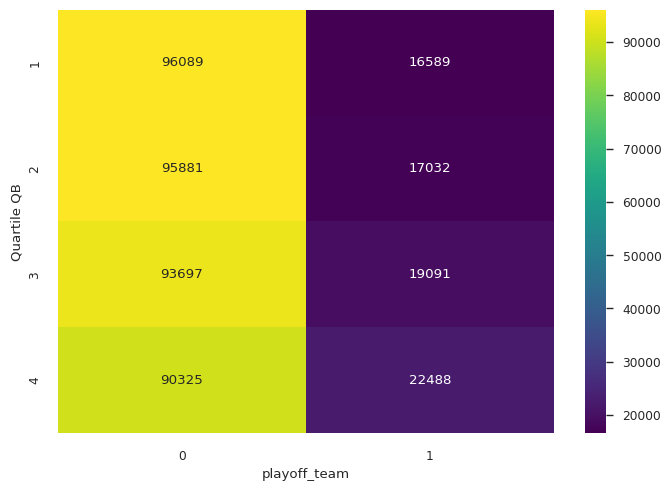

In [ ]:
df_q = entries.groupby(['playoff_team', 'Quartile QB']).size().unstack(level=0)
sns.heatmap(df_q, annot=True, fmt="g", cmap='viridis')

It's a very clear trend for QBs. The higher the standard deviation of prior year EPA among the QBs you drafted, the better your playoff odds.

16.7% of all entries make the playoffs, so this is our baseline for comparison. Bucket 1 and Bucket 2, the entries with below average standard deviation values, made the playoffs only 14.7% and 15.1% of the time, respectively. Meanwhile, Bucket 3 teams advanced 16.9% of the time and teams in Bucket 4 with the highest standard deviations advanced nearly 20% of the time.


<Axes: xlabel='playoff_team', ylabel='Quartile RB'>

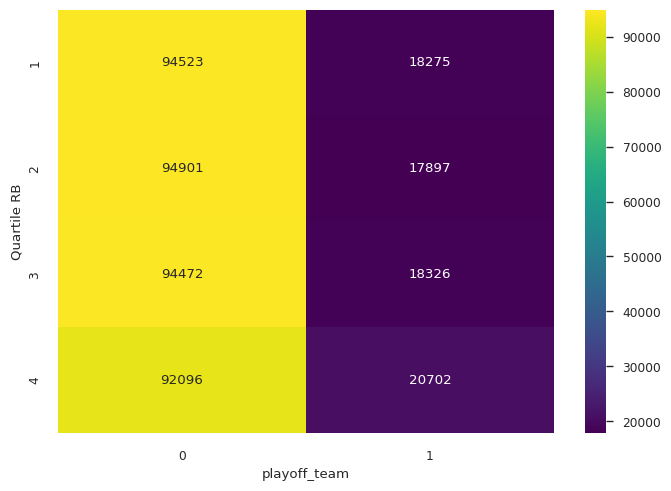

In [ ]:
df_r = entries.groupby(['playoff_team', 'Quartile RB']).size().unstack(level=0)
sns.heatmap(df_r, annot=True, fmt="g", cmap='viridis')

While not as clear a pattern as for QBs, we still have a nice trend for RBs. You don't hurt your playoff odds dramatically by having lower standard deviations, though entries within the highest quartile of standard deviations (i.e. Bucket 4) had an advance rate of 18.4%.

<Axes: xlabel='playoff_team', ylabel='Quartile WR'>

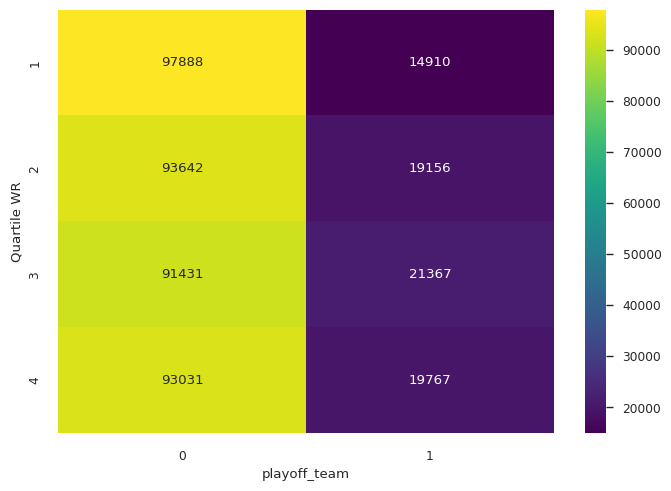

In [ ]:
df_w = entries.groupby(['playoff_team', 'Quartile WR']).size().unstack(level=0)
sns.heatmap(df_w, annot=True, fmt="g", cmap='viridis')

Alternatively, for WRs, you wanted to avoid having a very low standard deviation value in prior year EPA. Entries in Bucket 1 only had a 13.2% advance rate in BBM3.

<Axes: xlabel='playoff_team', ylabel='Quartile TE'>

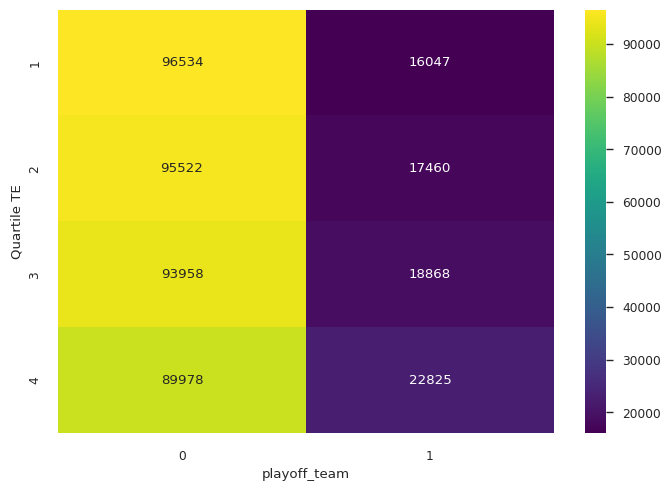

In [ ]:
df_t = entries.groupby(['playoff_team', 'Quartile TE']).size().unstack(level=0)
sns.heatmap(df_t, annot=True, fmt="g", cmap='viridis')

For TEs, the pattern is very similar to QBs. As your standard deviation of prior year EPA increases, so do your odds of making the playoffs. Entries in Bucket 4 with the highest standard deviations had a 20.2% advance rate in BBM3, well above the average mark of 16.7%.

<Axes: xlabel='playoff_team', ylabel='QB EPA Per Game Std'>

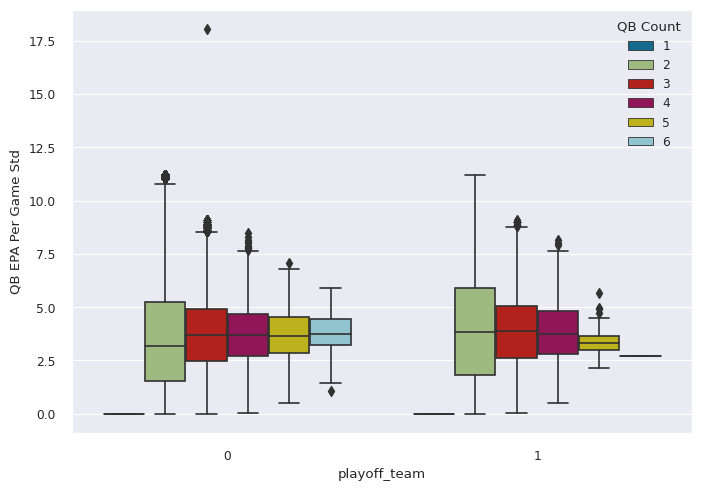

In [ ]:
sns.boxplot(data=entries, x="playoff_team", y="QB EPA Per Game Std", hue="QB Count")

<Axes: xlabel='playoff_team', ylabel='RB EPA Per Game Std'>

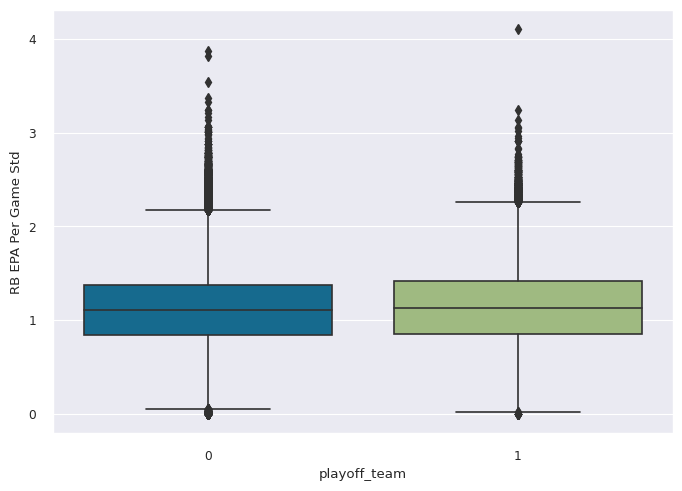

In [ ]:
sns.boxplot(data=entries, x="playoff_team", y="RB EPA Per Game Std")

<Axes: xlabel='playoff_team', ylabel='WR EPA Per Game Std'>

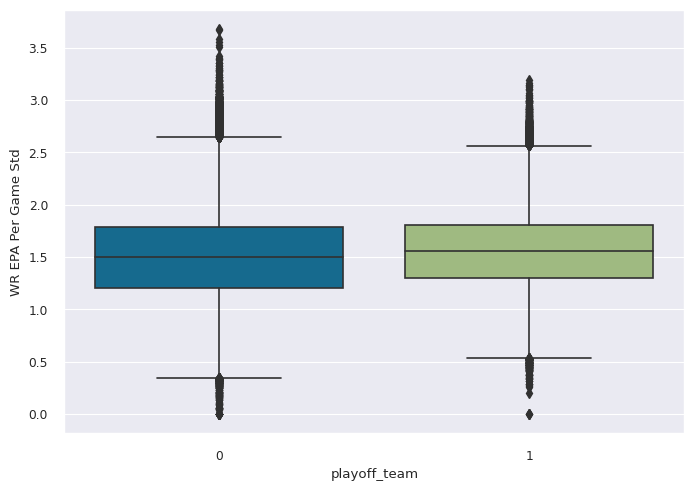

In [ ]:
sns.boxplot(data=entries, x="playoff_team", y="WR EPA Per Game Std")

<Axes: xlabel='playoff_team', ylabel='TE EPA Per Game Std'>

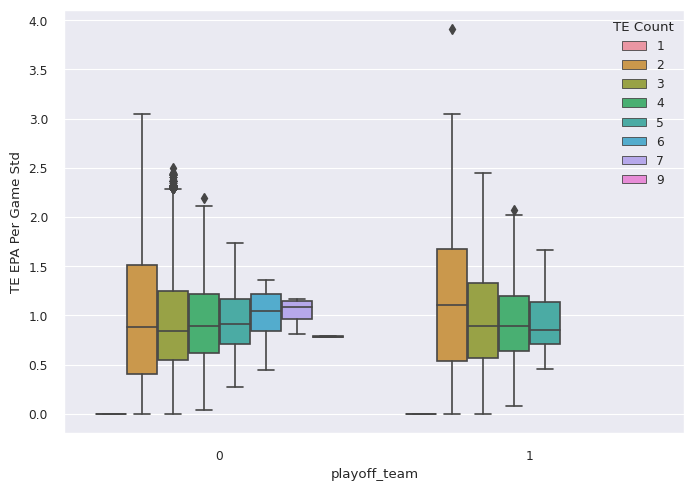

In [ ]:
sns.boxplot(data=entries, x="playoff_team", y="TE EPA Per Game Std", hue="TE Count")

The above box plots split entries on the x-axis into whether they missed or made the playoffs. The y-axis is the standard deviation of per game EPA from 2021 for the players each entry drafted. For QBs and TEs, I'm providing an additional level of detail based on the number of QBs and TEs drafted to compare on that variable as well. For each graph, you can see the median standard deviation value is higher for playoff teams than it is for non-playoff teams.

##Conclusion

So, there is a pattern where entries with higher prior year EPA standard deviations have a materially better chance of making the playoffs. This pattern exists for both BBM3 and BBM2. And it holds when you focus only on EPA standard deviations and hold other variables constant using partial dependence plots. Let's dig into why this might be happening and how we can use this in BBM4.

To start off, an interesting example is Diontae Johnson. Diontae Johnson finished 2022 with a per game EPA value of -0.3, which ranked 114th among WRs. According to ESPN Analytics, Diontae Johnson finished with the 5th highest receiver rating score and the highest Open score among all WRs in 2022. He's currently going as WR37 in BBM4.

Now, Diontae Johnson very famously scored 0 touchdowns in 2022, and that did not help his EPA value. What hurt his EPA value even more were the Steelers interceptions when he was the target. According to Sports Info Solutions, Diontae Johnson was the target on 6 of the team's 14 interceptions in 2022. Turnover rates are a bit fluky, meaning his EPA could swing massively in 2023 as it's not a given these turnovers will persist. We can also combine that with an historically-low TD rate and a lot of off target throws, both things that could change in 2023. If his ADP is being dragged down by these factors, adding in Diontae Johnson could boost both your EPA standard deviation and playoff odds.

For RBs, an interesting example was an entry in BBM3 that only drafted two running backs. Those RBs were Christian McCaffrey and Josh Jacobs. This entry had one of the highest EPA standard deviations at RB for the tournament. Now, we should use multiple best ball strategies together, so I don't recommend only drafting two RBs. This increases your chances drastically of getting 0 points from your RB slot and guarantees it during bye weeks. However, these two RBs are interesting in that they play very different roles. McCaffrey had a strong positive EPA per game value in 2021 due to his receiving ability; he matched Jacobs' full season receiving yards in seven games. Alternatively, Jacobs' 2021 EPA per game was negative; EPA values tend to be positive on pass plays and negative on run plays.

A hypothesis, then, is drafting players with diverse roles/skillsets may improve your weekly scoring floor and ceiling. As another example, pairing a traditional pocket passer with an above-average passing EPA value and a rushing QB would typically be a way to increase the standard deviation of prior year EPA.

In summary, there is a benefit to building a team that has a diverse EPA outcome from the prior season. If torn between two players on the clock in a BBM4 draft, consider opting for the player that increases the EPA standard deviation of your position group. If you can find specific players, like a Diontae Johnson, who had a low EPA value due to reasons that could likely reverse, all the better. Similarly, consider adding a player with a different skillset than a player you've already drafted at a position, as this will likely increase your EPA standard deviation and improve your playoff odds.
